In [ ]:
#!/usr/bin/env python3
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset(["tfrecords/dichasus-0053.tfrecords", "tfrecords/dichasus-0054.tfrecords", "tfrecords/dichasus-0055.tfrecords", "tfrecords/dichasus-0056.tfrecords", "tfrecords/dichasus-0057.tfrecords"])

feature_description = {
	"csi": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"pos-lidar": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"rot": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
	"snr": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"time": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
}
			
def record_parse_function(proto):
	record = tf.io.parse_single_example(proto, feature_description)

	# Channel coefficients for all antennas, over all subcarriers, real and imaginary parts
	csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type = tf.float32), (32, 1024, 2))

	# Position of transmitter determined by vacuum robot LIDAR, in meters (X / Y coordinates)
	pos_lidar = tf.ensure_shape(tf.io.parse_tensor(record["pos-lidar"], out_type = tf.float64), (2))

	# Rotation of robot relative to its initial parking position, in radians
	rot = tf.ensure_shape(record["rot"], ())

	# Signal-to-Noise ratio estimates for all antennas
	snr = tf.ensure_shape(tf.io.parse_tensor(record["snr"], out_type = tf.float32), (32))

	# Timestamp since start of measurement campaign, in seconds
	time = tf.ensure_shape(record["time"], ())

	return csi, pos_lidar, rot, snr, time
			
dataset = raw_dataset.map(record_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Optional: Cache dataset in RAM for faster training
dataset = dataset.cache()

In [ ]:
for x in dataset:
    print("CSI shape:", x[0].numpy())
    print("Position (GNSS):", x[1].numpy())
    print("SNR:", x[2].numpy())
    print("Standard Deviation (GNSS):", x[3].numpy())
    print("Time:", x[4].numpy())
    break

In [ ]:
ground_truth = dataset.map(lambda csi, pos_lidar, rot,snr, time: pos_lidar)

In [ ]:
csi = dataset.map(lambda csi, pos_lidar, rot,snr, time: csi)

In [ ]:
csi._shape_invariant_to_type_spec

In [ ]:
for x in csi:
    print("First CSI:", x.numpy().shape)
    break

In [ ]:
import tensorflow as tf
import numpy as np
gns_pos=np.vstack([x.numpy() for x in ground_truth])

In [ ]:
gns_pos[0]

In [ ]:
csi_np=np.vstack([x.numpy() for x in csi])

In [ ]:
csi_np=csi_np.reshape(-1,32,1024,2)

In [ ]:
csi_np.shape

In [ ]:
csi_real= csi_np[:, :, :,0]
csi_imag = csi_np[:, :, :,1]

In [ ]:
csi_real.shape, csi_imag.shape

In [ ]:
CSI = tf.complex(csi_real, csi_imag)

In [ ]:
import matplotlib.pyplot as plt

# Plotting the ground truth positions
plt.figure(figsize=(10, 6))
plt.scatter(gns_pos[:, 0], gns_pos[:, 1], c='blue', label='Ground Truth Position (GNSS)')
plt.title('Ground Truth Position (GNSS)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid()
plt.show()

In [58]:
import numpy as np

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_hard_probability_maps(positions, grid_points):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    closest_indices = np.argmin(dists, axis=1)
    prob_maps = np.zeros((N, K))
    prob_maps[np.arange(N), closest_indices] = 1.0
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    
    prob_maps = compute_hard_probability_maps(positions, grid_points)
    est_locations = estimate_positions_from_maps(prob_maps, grid_points)
    
    return prob_maps, est_locations, grid_points

In [59]:
from scipy.signal import convolve2d
def feature_extraction(H):
    H_bar = np.fft.ifft(H, axis=1)
    H_bar_star = np.conj(H_bar)
    R = convolve2d(H_bar, np.flip(H_bar_star), mode='full')
    r = R.flatten('F')
    rR = np.concatenate([r.real, r.imag])
    eps = 1e-12  # Small epsilon for numerical stability
    f1 = rR / (np.linalg.norm(rR) + eps)
    return f1

In [60]:
CSI.shape

TensorShape([26161, 32, 1024])

In [61]:
CSI_train=CSI[:1000,:8,:]

In [62]:
CSI_train.shape

TensorShape([1000, 8, 1024])

In [63]:
print(CSI_train[0])

tf.Tensor(
[[ 4.677066 +5.6480703j   4.847598 +5.4856462j   4.838405 +5.524256j
  ...  4.992615 +5.503038j    4.9786806+5.5077133j
   4.964582 +5.5506005j ]
 [-4.335247 -0.6367858j  -4.3260746-0.51643324j -4.3296833-0.5110897j
  ... -4.4847803-0.48019722j -4.467213 -0.47334757j
  -4.4673877-0.49514312j]
 [-0.456782 -3.9246633j  -0.6060356-3.8824916j  -0.6376779-3.9059012j
  ... -0.5795499-3.9791732j  -0.5913298-3.9797091j
  -0.5953056-3.975963j  ]
 ...
 [ 2.5667682+1.9678484j   2.67866  +1.8701632j   2.7189217+1.8778446j
  ...  2.5685527+1.8532867j   2.6147842+1.8324354j
   2.622672 +1.9002281j ]
 [-2.9449644-2.4817567j  -3.0263207-2.3344438j  -3.011119 -2.3466198j
  ... -3.0929508-2.450378j   -3.093848 -2.4328966j
  -3.0914283-2.3982744j ]
 [-2.5458493-1.8926824j  -2.5869908-1.842829j   -2.5927744-1.8458394j
  ... -2.6559112-1.8191203j  -2.61874  -1.7957598j
  -2.6424384-1.8442758j ]], shape=(8, 1024), dtype=complex64)


In [64]:
y=np.vstack([feature_extraction(x) for x in CSI_train])

In [65]:
y.shape

(1000, 61410)

In [66]:
gns_pos_train=gns_pos[:1000,:]

In [67]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(y, gns_pos_train, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

In [68]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=30)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=30)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=30)

Position bounds: (-5.171132606721162, 0.006) (-0.1641860465116279, 2.947381688466045)
Grid points shape: (900, 2)
Position bounds: (-5.177490463215259, 0.006) (-0.15770047543581617, 2.947726840855213)
Grid points shape: (900, 2)
Position bounds: (-5.1526552538370725, 0.006) (-0.15762097378277154, 2.9307544128933087)
Grid points shape: (900, 2)


In [69]:
import tensorflow as tf
from keras import layers, models, regularizers
def build_csi_probmap_mlp(input_dim: int = 61410,hidden_units: tuple = (1024, 1024, 512, 256),dropout_rate: float = 0.2,l2_coeff: float = 0.0) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for width in hidden_units:
        x = layers.Dense(width,activation='gelu',kernel_regularizer=regularizers.l2(l2_coeff))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(900, activation=None)(x)
    outputs = layers.Activation("sigmoid")(logits)
    return models.Model(inputs, outputs)


In [70]:
pred_ds = tf.data.Dataset.from_tensor_slices((X_pred, prob_map_pred))
pred_ds = pred_ds.shuffle(buffer_size=1024).batch(32)

In [71]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, prob_map_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

In [72]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, prob_map_test))
test_ds = test_ds.shuffle(buffer_size=1024).batch(32)

In [73]:
model2 = build_csi_probmap_mlp()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
model2.fit(train_ds, epochs=30, validation_data=pred_ds)

Epoch 1/30


2025-08-01 22:18:43.573447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.3100

2025-08-01 22:18:45.576252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 3s 78ms/step - loss: 0.6674 - accuracy: 0.3100 - val_loss: 0.6617 - val_accuracy: 0.7600
Epoch 2/30
19/19 [==============================] - 1s 49ms/step - loss: 0.3434 - accuracy: 0.6983 - val_loss: 0.4758 - val_accuracy: 0.7600
Epoch 3/30
19/19 [==============================] - 1s 48ms/step - loss: 0.1080 - accuracy: 0.7283 - val_loss: 0.2274 - val_accuracy: 0.7600
Epoch 4/30
19/19 [==============================] - 1s 48ms/step - loss: 0.0386 - accuracy: 0.7517 - val_loss: 0.0882 - val_accuracy: 0.7600
Epoch 5/30
19/19 [==============================] - 1s 62ms/step - loss: 0.0196 - accuracy: 0.7533 - val_loss: 0.0401 - val_accuracy: 0.7600
Epoch 6/30
19/19 [==============================] - 1s 54ms/step - loss: 0.0128 - accuracy: 0.7550 - val_loss: 0.0315 - val_accuracy: 0.7600
Epoch 7/30
19/19 [==============================] - 1s 48ms/step - loss: 0.0098 - accuracy: 0.7533 - val_loss: 0.0217 - val_accuracy: 0.7600
Epoch 8/30
19/19 [======

In [75]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(30, 30), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

7/7 [==============================] - 0s 11ms/step


2025-08-01 22:19:13.572609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


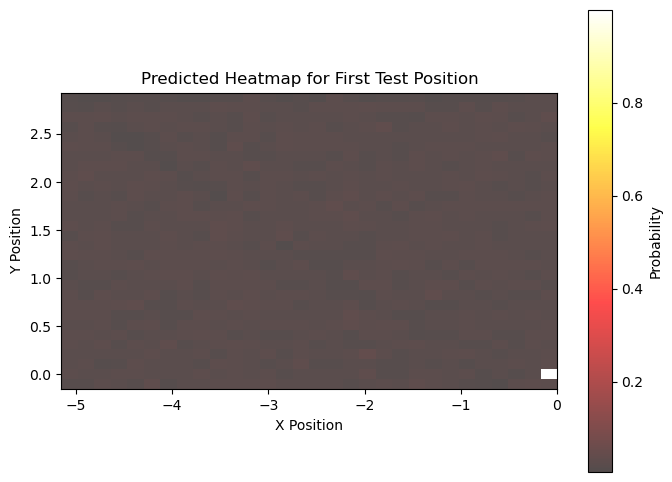

Estimated :- [-46.91168652  24.89114407]
Ground Truth :- [ 0.006 -0.066]


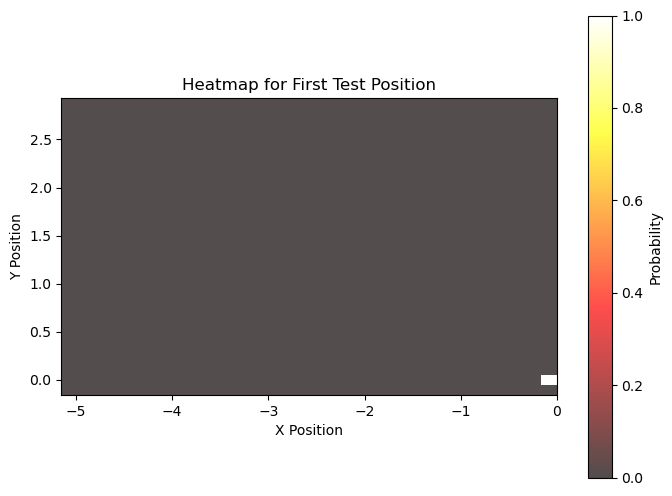

Mean Absolute Error (Position Predictions): [41.31148732 22.31485168]


In [76]:
predicted_maps = model2.predict(X_pred)
plot_heatmap(predicted_maps[2], grid_points_pred, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_pred)[2]}")
print(f"Ground Truth :- {y_pred[2]}")
plot_heatmap(prob_map_pred[2], grid_points_pred, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_pred)
mae = np.mean(np.abs(y_pred - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

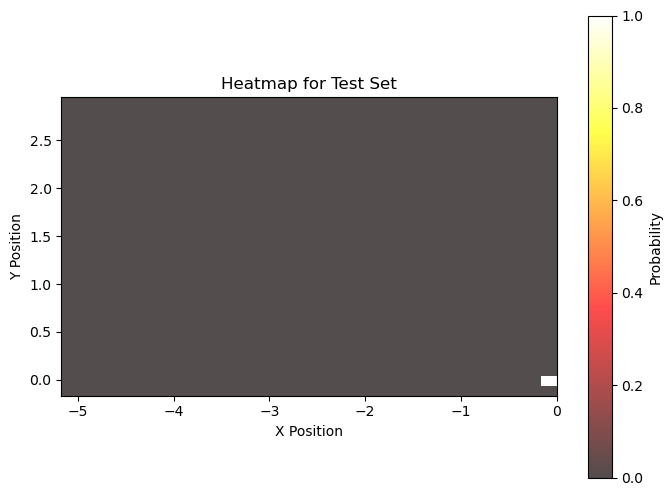

In [77]:
plot_heatmap(prob_map_test[0], grid_points_test, title="Heatmap for Test Set")

In [78]:
jk=estimate_positions_from_maps(predicted_maps, grid_points_pred)

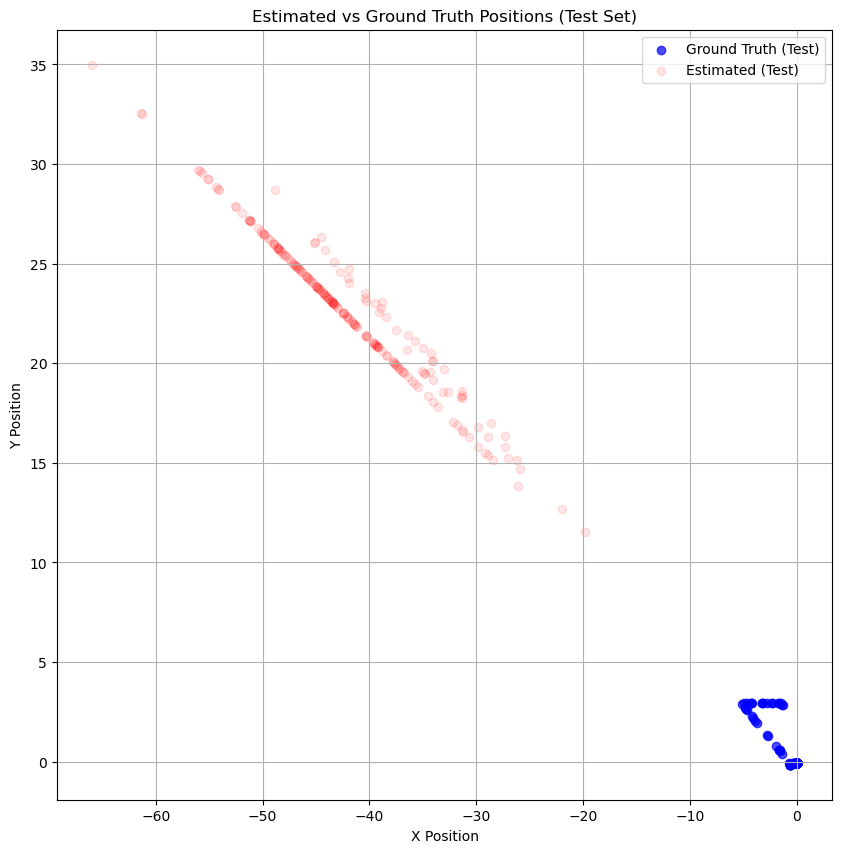

In [79]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.7)
plt.scatter(jk[:, 0], jk[:, 1], c='red', label='Estimated (Test)', alpha=0.1)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
def random_attack(CFR, lp=None, cp_len=20, epsilon=1.0, align='pad'):
    m, rows, n_subcarriers = CFR.shape  # (m, 32, 1024)
    
    # Generate random perturbation for each m (shared across 32 rows)
    A = np.random.uniform(0, 1, (m, lp))
    phi = np.random.uniform(0, 2 * np.pi, (m, lp))
    base = A * (np.cos(phi) + 1j * np.sin(phi))  # shape (m, lp)
    
    if cp_len:
        cp = base[:, -cp_len:]
        base = np.concatenate([cp, base], axis=-1)  # shape (m, lp + cp_len)
    
    # Pad or truncate to match n_subcarriers dimension
    if base.shape[-1] < n_subcarriers:
        # Pad with zeros
        padding = np.zeros((m, n_subcarriers - base.shape[-1]))
        perturbation = np.concatenate([base, padding], axis=-1)
    else:
        # Truncate if base is longer than n_subcarriers
        perturbation = base[:, :n_subcarriers]
    
    # Apply FFT along the last dimension
    perturbation = np.fft.fft(perturbation, axis=-1)
    
    # Normalize each perturbation vector to unit ℓ₂ norm
    norm = np.linalg.norm(perturbation, axis=-1, keepdims=True)
    perturbation = perturbation / norm
    
    # Apply epsilon scaling and broadcast to match CFR shape
    perturbation = epsilon * perturbation[:, np.newaxis, :]  # shape (m, 1, 1024)
    
    return CFR * perturbation

In [91]:
bange=range(2,10,1)

In [87]:
prob_map, est_locations, grid_points = generate_all_probability_maps(gns_pos_train, grid_size=30)

Position bounds: (-5.177490463215259, 0.006) (-0.1641860465116279, 2.947726840855213)
Grid points shape: (900, 2)


In [ ]:
#store the features in a file which can be used later 
# import numpy as np
# np.save('features_F1_cir.npy', y)

In [92]:
mde_vals=[]
for x in bange:
    lp_length = x
    CFR_adv = random_attack(CSI_train, lp=lp_length, cp_len=20, align='pad')
    features_F1_cir_adv2 = np.array([feature_extraction(cfr) for cfr in CFR_adv])
    predicted_maps_adv2 = model2.predict(features_F1_cir_adv2)
    predicted_positions_adv2 = np.matmul(predicted_maps_adv2, grid_points)
    mde_adv2 = np.mean(np.sqrt((gns_pos_train[:, 0] - predicted_positions_adv2[:, 0]) ** 2 + (gns_pos_train[:, 1] - predicted_positions_adv2[:, 1]) ** 2), axis=0)
    mde_vals.append(mde_adv2)

32/32 [==============================] - 0s 5ms/step


In [93]:
mde_vals

[23.91226812263072,
 21.524151260908322,
 25.468761327663316,
 40.59978317619149,
 28.36212603427157,
 27.694993701194377,
 27.98116793235415,
 32.84165317475107]

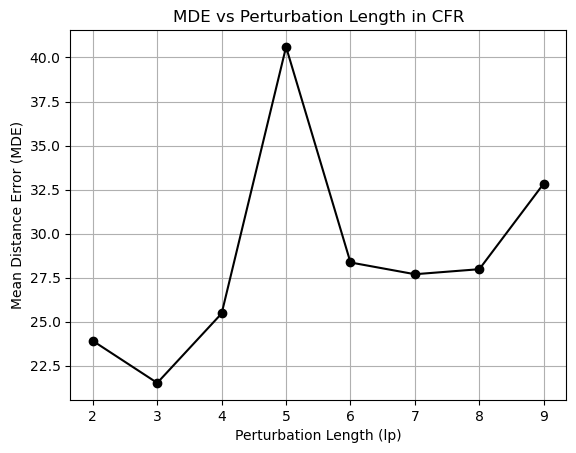

In [94]:
#plot the MDE values
import matplotlib.pyplot as plt
plt.plot(bange, mde_vals, marker='o', linestyle='-', color='black')
plt.title('MDE vs Perturbation Length in CFR')
plt.xlabel('Perturbation Length (lp)') 
plt.ylabel('Mean Distance Error (MDE)')
plt.grid(True)
plt.show()